In [1]:
import os
import glob
import time
import json

import networkx as nx
import math

## Setup Plot Settings

In [2]:
import pylab
pylab.rcParams['xtick.major.pad']='8'
pylab.rcParams['ytick.major.pad']='8'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(12.0)
panel_label_font.set_family("sans-serif")

# Data Paths

In [38]:
data_path = "/DATA/7A/assets/erc721networks/CryptoKitties/"

graph_name = "CryptoKitties"

In [39]:
with open(data_path + graph_name + '.json') as f:
    graph_info = json.load(f)
graph_info['name'], graph_info['#nodes'], graph_info['#edges']

('CryptoKitties', 115763, 5450248)

# Create NetworkX Graph

In [ ]:
#create multidigraph
edges = graph_info["edges"]

graph = nx.MultiDiGraph()
for e in edges:
    u = e[0]
    v = e[1]
    t = e[2]
    graph.add_edge(u, v, timestamp=t)

nx.info(graph)
#print("Reciprocity of "+graph_name+" is:", nx.overall_reciprocity(graph))
print("Assortativity of "+graph_name+" is:", nx.degree_pearson_correlation_coefficient(graph))

Reciprocity of CryptoKitties is: 0.33983848074436246


### get gephi output

In [11]:
# Export to Gexf file.
nx.write_gexf(graph, '{}'.format(data_path + graph_name + ".gexf"))

## create network snapshots

In [12]:
time_period = 60*60*24*90 # 90 day periods

mindelta = edges[0][2]
maxdelta = edges[0][2]
for e in edges:
    if e[2] > maxdelta:
        maxdelta = e[2]
    if e[2] < mindelta:
        mindelta = e[2]
print(mindelta, maxdelta)
duration = maxdelta - mindelta
num_snapshots = math.ceil(duration / time_period)
print("Number of snapshots", num_snapshots)

graphs = []
for x in range(0,num_snapshots):
    #tg = nx.MultiDiGraph()
    #tg["name"] = str(x)
    graphs.append(nx.MultiDiGraph())
    

for u,v,t in graph.edges(data=True):
    idx = math.floor((t["timestamp"] - mindelta) / time_period)
    graphs[idx].add_edge(u, v)
    
for g in graphs:
    print(nx.info(g))

1571396339 1615234759
Number of snapshots 6
Name: 
Type: MultiDiGraph
Number of nodes: 70
Number of edges: 275
Average in degree:   3.9286
Average out degree:   3.9286
Name: 
Type: MultiDiGraph
Number of nodes: 475
Number of edges: 4751
Average in degree:  10.0021
Average out degree:  10.0021
Name: 
Type: MultiDiGraph
Number of nodes: 661
Number of edges: 5680
Average in degree:   8.5930
Average out degree:   8.5930
Name: 
Type: MultiDiGraph
Number of nodes: 6555
Number of edges: 23943
Average in degree:   3.6526
Average out degree:   3.6526
Name: 
Type: MultiDiGraph
Number of nodes: 8293
Number of edges: 27085
Average in degree:   3.2660
Average out degree:   3.2660
Name: 
Type: MultiDiGraph
Number of nodes: 16542
Number of edges: 27103
Average in degree:   1.6384
Average out degree:   1.6384


# Analysis

In [13]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

## hub vertices

- which tokens share hubs? (if they share any)

- can we find liquidity providers by checking neighbors of hub vertices?


In [14]:
degrees = graph.degree
print("All time:")
print(sorted(degrees, key=lambda t: t[1], reverse=True)[:5])
c = 0
for g in graphs:
    print("T =", c)
    c += 1
    print(sorted(g.degree, key=lambda t: t[1], reverse=True)[:5])

All time:
[('0x0000000000000000000000000000000000000000', 66354), ('0x8124b02b4967bd7338a450420a572d574915ff9c', 1779), ('0xa7b3f922e1e2ad432a424c0fe887db9b4f1350ea', 1187), ('0xcd4fec10c8ad4873e209062b31defb684ff8cb7c', 805), ('0x1e27f4ac6e6dc1a1adfc95d9dfd4b3498fdab3f3', 526)]
T = 0
[('0x0000000000000000000000000000000000000000', 192), ('0x4765273c477c2dc484da4f1984639e943adccfeb', 37), ('0x4f31bfdee182626076e98a2aa6cbef2d490bda4c', 24), ('0x7cdaceae587e02d94e276856b91d0cf89312baf9', 21), ('0x136cf48defae1675856bc90cc522c678bd6b8334', 17)]
T = 1
[('0x0000000000000000000000000000000000000000', 3236), ('0xcd4fec10c8ad4873e209062b31defb684ff8cb7c', 657), ('0x8124b02b4967bd7338a450420a572d574915ff9c', 519), ('0x50aa3eaefdbec5fe1fba5b419b77126475188691', 270), ('0xa7b3f922e1e2ad432a424c0fe887db9b4f1350ea', 220)]
T = 2
[('0x0000000000000000000000000000000000000000', 3866), ('0x8124b02b4967bd7338a450420a572d574915ff9c', 632), ('0xa7b3f922e1e2ad432a424c0fe887db9b4f1350ea', 365), ('0xe703f231

## degree distribution

- is there a difference between erc20 and erc721 degree distributions?
- user profiling => degree distribution of users across graphs 
- user activity profiling => temporal degree distribution 
    - for diffent time granularities

Creating histogram...
Creating histogram...
Creating histogram...
Creating histogram...
Creating histogram...
Creating histogram...
Creating histogram...


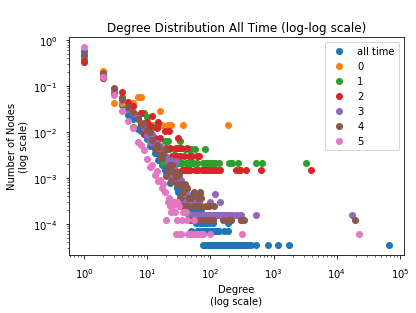

In [15]:
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

x, y = plot_degree_histogram(graph)
plt.title('\nDegree Distribution All Time (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
plt.plot(x, y, 'o', label = "all time")

c = 0
for g in graphs:
    x, y = plot_degree_histogram(g)
    plt.plot(x, y, 'o', label=c)
    c += 1
plt.legend()

- degree distribution could show us whales in marketplaces?
- nft galleries? :)
    
**Degree distribution at a **

- degree distribution change 

# pdf

powerlaw package
fit a power law curve
how th exponent is changing over time

* cdf of the data

In [16]:
degrees = graph.degree
data = [i[1] for i in degrees]
fit = powerlaw.Fit(data)
print(fit.power_law.alpha)
print(fit.power_law.sigma)
fit.distribution_compare('power_law', 'lognormal_positive')

2.487695016336614
0.08632482040695044


Calculating best minimal value for power law fit
/home/aakyildiz/anaconda3/envs/erc/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


(4.974224269807256, 0.34446616515684636)

In [27]:
for g in graphs:
    degrees = g.degree
    data = [i[1] for i in degrees]
    fit = powerlaw.Fit(data)
    print(fit.power_law.alpha)
    print(fit.power_law.sigma)
    print(fit.distribution_compare('power_law', 'lognormal_positive'))

2.426357347897228
0.29741606663279363
(0.8481719383098025, 0.3828628623623028)
1.8942342564724912
0.07557658865817174
(1.6031275159357312, 0.5227967891531149)
2.229630341112731
0.1812991028410745
(1.3317073130009507, 0.2557958157532534)
2.503992483659087
0.09004167475786322
(6.564652448543326, 0.21812218363187785)
2.6868753009963156
0.11171604592517276
(5.801528613277858, 0.30982250863454075)
2.9575987355863926
0.13672462638937566
(13.887299148222313, 0.1769264176379982)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


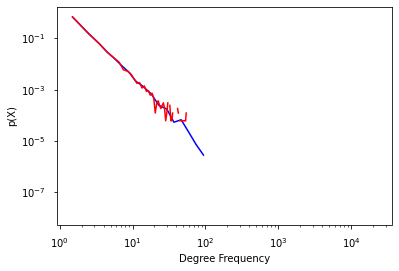

In [18]:
figPDF = powerlaw.plot_pdf(data, color='b')
powerlaw.plot_pdf(data, linear_bins=True, color='r', ax=figPDF)

figPDF.set_ylabel("p(X)")
figPDF.set_xlabel(r"Degree Frequency")
figname = 'Degree Distribution'

In [22]:
def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    #plot_pdf(data[data>0], ax=ax1, color='b', linewidth=2)
    plot_pdf(data, ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)

    if data_inst==1:
        ax1.annotate("A", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    ax1in = inset_axes(ax1, width = "30%", height = "30%", loc=3)
    ax1in.set_xticks([])
    ax1in.set_yticks([])

    
    ax2 = fig.add_subplot(n_graphs,n_data,n_data+data_inst, sharex=ax1)
    plot_pdf(data, ax=ax2, color='b', linewidth=2)
    fit = Fit(data, xmin=1, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle=':', color='g')
    p = fit.power_law.pdf()

    ax2.set_xlim(ax1.get_xlim())
    
    fit = Fit(data, discrete=True)
    fit.power_law.plot_pdf(ax=ax2, linestyle='--', color='g')
    from pylab import setp
    setp( ax2.get_xticklabels(), visible=False)

    if data_inst==1:
       ax2.annotate("B", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)        
       ax2.set_ylabel(u"p(X)")# (10^n)")
        
    ax3 = fig.add_subplot(n_graphs,n_data,n_data*2+data_inst)#, sharex=ax1)#, sharey=ax2)
    fit.power_law.plot_pdf(ax=ax3, linestyle='--', color='g')
    fit.exponential.plot_pdf(ax=ax3, linestyle='--', color='r')
    fit.lognormal.plot_pdf(ax=ax3, linestyle='--', color='b')
    #fit.lognormal.plot_pdf(ax=ax3, linestyle='--', color='b')
    fit.plot_pdf(ax=ax3, color='b', linewidth=2)
    
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_xlim(ax1.get_xlim())
    
    if data_inst==1:
        ax3.annotate("C", annotate_coord, xycoords="axes fraction", fontproperties=panel_label_font)

    ax3.set_xlabel(units)

<ipython-input-22-ad0393abef1f>:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes
/home/aakyildiz/anaconda3/envs/erc/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/home/aakyildiz/anaconda3/envs/erc/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/aakyildiz/anaconda3/envs/erc/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/aakyildiz/anaconda3/envs/erc/lib/python3.9/site-packages/powerlaw.py:1560: RuntimeWarning: invalid value encountered in true_divide
  r

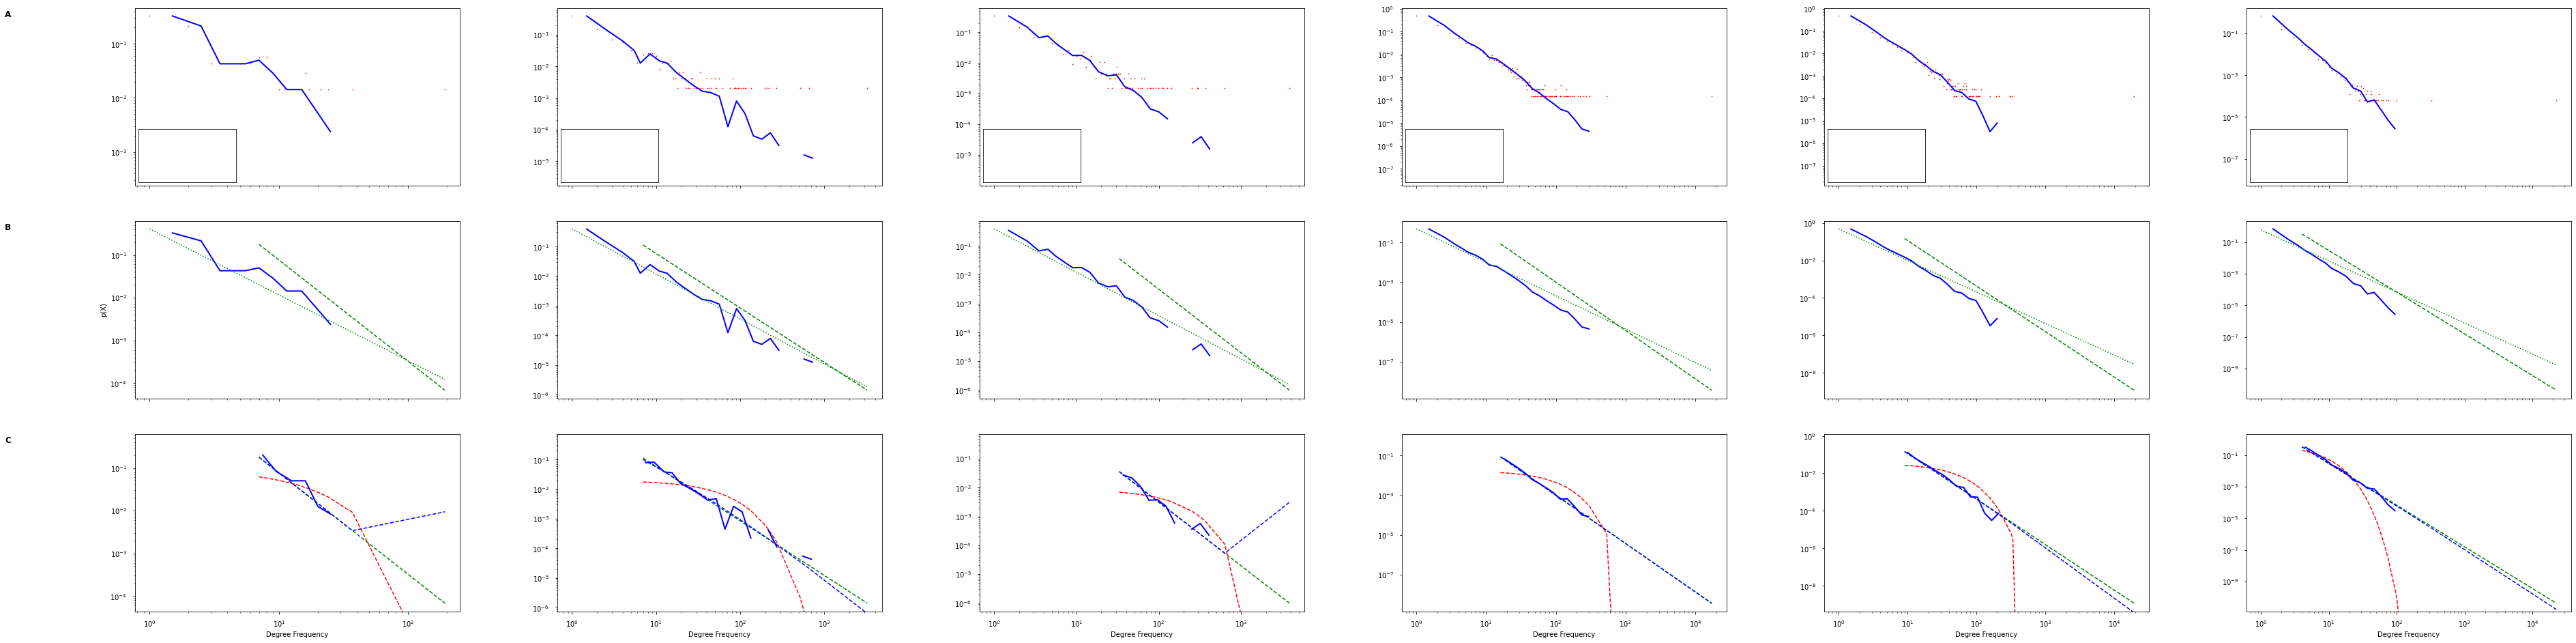

In [23]:
n_data = len(graphs)
n_graphs = 4
f = plt.figure(figsize=(64,22))

data_inst = 1
for g in graphs:
    degrees = g.degree
    data = [i[1] for i in degrees]
    units = 'Degree Frequency'
    plot_basics(data, data_inst, f, units)
    data_inst += 1

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.2)
figname = 'FigWorkflow'
f.savefig(figname+'.png', bbox_inches='tight')
#f.savefig(figname+'.tiff', bbox_inches='tight', dpi=300)